# Super Tic-Tac-Toe Reinforcement Learning Project Report

## 1. Modeling Cross Tic-Tac-Toe as a Markov Decision Process

Cross Tic-Tac-Toe can be effectively modeled as a Markov Decision Process (MDP) because:

- **States**: The game state can be represented by the current board configuration, which fully captures all relevant information needed for decision-making.

- **Actions**: At each step, the agent can choose from available moves (empty cells) on the board.

- **Transitions**: The state transitions are deterministic when the agent makes a move, and partially stochastic when the opponent places a piece (due to the random placement rule).

- **Rewards**: Immediate rewards signal the quality of actions: win (+1), loss (-1), draw (0), and penalties for invalid moves.

- **Markov Property**: The future state depends only on the current state and action, not on the history of how the current state was reached.

The Markov property is particularly important as it allows the agent to make decisions based solely on the current board configuration without needing to remember previous moves. This makes the problem tractable with standard RL algorithms.

## 2. Environment Setup

The Cross Tic-Tac-Toe environment introduces a twist to the traditional game:

- **Board Structure**: Instead of a 3×3 grid, the game uses a cross-shaped board with multiple cells. The board expands in curriculum stages from simple to complex.

- **Random Placement Rule**: When a player selects a position, there's a 50% chance the piece will be placed in a randomly chosen adjacent cell instead of the selected one.

- **Curriculum Stages**:
  - Stage 1: Simple board (central cells only)
  - Stage 2: Medium board (central cells + one arm)
  - Stage 3: Full cross-shaped board
  - Stage 4: Full board with increasingly sophisticated opponents

- **Win Condition**: Aligning pieces in a row, column, or diagonal (similar to traditional Tic-Tac-Toe but adapted to the cross-shaped board).

- **Observation Space**: The board state is represented as a 1D array, where values indicate empty (0), agent's pieces (1), or opponent's pieces (-1).

- **Action Space**: A discrete set of actions corresponding to the available positions on the board.

- **Reward Structure**:
  - Win: +1
  - Draw: 0
  - Loss: -1
  - Invalid move: -0.01
  - Shaped reward: Small positive rewards for creating potential winning lines (Three in a row)

## 3. Algorithms and Deep Learning Models

### Dueling DQN Architecture

The project implements a Dueling DQN architecture, which separates the state value and advantage estimation. This separation allows the network to learn which states are valuable without having to learn the effect of each action for each state.

In mathematical terms, a traditional DQN calculates Q-values directly:

Q(s, a) = Network(s, a)

Whereas a Dueling DQN calculates:

Q(s, a) = V(s) + A(s, a) - 1/|A| * Σ_a' A(s, a')

Where:
- V(s) is the state value function (how good is it to be in state s)
- A(s, a) is the advantage function (how much better is action a compared to other actions)
- The subtraction of the mean advantage normalizes the advantage values

This architecture consists of:
- A shared feature extraction network
- A value stream estimating V(s)
- An advantage stream estimating A(s, a) for each action

### Double DQN Implementation (Shadow Network)

A key component of our solution is the Double DQN approach, which uses a shadow (target) network to stabilize training. The standard Q-learning update rule is:

Q(s, a) ← Q(s, a) + α[r + γ max_a' Q(s', a') - Q(s, a)]

This can suffer from overestimation bias because the same network is used to select and evaluate actions. Double DQN addresses this by using two networks:

Q(s, a) ← Q(s, a) + α[r + γ Q_target(s', argmax_a' Q_policy(s', a')) - Q(s, a)]

Where:
- Q_policy is the online network that selects actions
- Q_target is the target network that evaluates those actions
- The target network is periodically updated to match the policy network

### Why Double DQN with Shadow Network is Ideal for This Problem

Double DQN with a shadow network (target network) is particularly well-suited for Cross Tic-Tac-Toe for several key reasons:

1. **Overcoming Estimation Bias**: 
   - Standard Q-learning tends to overestimate action values due to the max operation
   - In our game environment with random placement rules, this bias could be exacerbated, Double DQN decouples action selection from action evaluation, reducing this bias. This prevents the agent from being overly optimistic about uncertain moves

2. **Handling Stochasticity and large action space**:
   - The random placement mechanic introduces significant stochasticity and the action space is as large as 80.
   - Shadow network provides stable target values while learning in this noisy environment. This prevents the agent from chasing a "moving target" during updates

3. **Addressing Reward Sparsity**:
   - Game rewards (win/loss) are inherently sparse and delayed
   - Shadow network provides consistent estimation targets during the long trajectories toward terminal states
   - This helps connect the agent's current actions to delayed outcomes

5. **Implementation Details**:
   - Target update frequency: 10-20 steps (balanced stability vs. learning speed)
   - Soft update option: Gradually blending policy and target networks (τ = 0.01)
   - Initialization: Both networks start with the same weights
   - Memory efficiency: Shares feature extraction layers between networks

The shadow network is essential for our agent to learn consistent strategies in this environment where the same state-action pair might lead to different outcomes due to the random placement rule.

## 4. Training Techniques and Curriculum Learning

### Reward Shaping

The reward structure includes carefully designed shaped rewards to guide learning:

- **Basic Rewards**:
  - Win: +1.0
  - Draw: 0.0
  - Loss: -1.0
  - Invalid move penalty: -0.01

- **Shaped Rewards**:
  - +0.05 for creating 2-in-a-row formations
  - +0.1 for creating 3-in-a-row formations (in later curriculum stages)

Reward shaping is crucial in this environment because:
1. Terminal rewards (win/loss) are sparse and delayed
2. The random placement rule introduces uncertainty that can obscure the value of good moves
3. The curriculum stages require transferable strategies that can be built upon

### Curriculum Learning

The project implements a four-stage curriculum learning approach to gradually increase the complexity of the task:

#### Stage 1: Simple Board (Central Only)
- **Board Configuration**: Only the central portion of the cross is used (simplest version).
- **Advancement Criteria**: The agent advances when it achieves >80% win rate over 1000 episodes against a random opponent.
- **Training Focus**: Learning basic game mechanics and simple winning strategies.

#### Stage 2: Medium Board (Central + One Arm)
- **Board Configuration**: The central portion plus one arm of the cross.
- **Advancement Criteria**: The agent advances when it achieves >75% win rate over 1000 episodes against a random opponent.
- **Training Focus**: Learning to handle a larger board with more complex winning patterns.

#### Stage 3: Full Cross Board
- **Board Configuration**: The complete cross-shaped board.
- **Advancement Criteria**: The agent advances when it achieves >70% win rate over 1000 episodes against a random opponent.
- **Training Focus**: Mastering the full game mechanics and all possible winning patterns.

#### Stage 4: Roleplay Training
- **Board Configuration**: Full cross board.
- **Opponents**: The agent plays against previous versions of itself from different training stages.
- **Training Schedule**: 
  - Starts by playing against simpler opponents (earlier checkpoints)
  - Gradually faces increasingly sophisticated opponents (later checkpoints)
  - Ultimately plays against the most advanced versions of itself
- **Evaluation**: Performance is measured against both historical models and random strategy.

### Additional Training Techniques

- **Experience Replay Buffer**:
  - Stores (state, action, reward, next_state, done) tuples
  - Randomly samples experiences to break correlations between sequential experiences
  - Buffer size: 100,000 experiences
  - Batch size: 64 for stable gradient updates

- **Epsilon-Greedy Exploration**:
  - Starting epsilon: 1.0 (full exploration)
  - Ending epsilon: 0.05 (5% random actions)
  - Decay rate: 10,000 steps
  - Ensures thorough exploration of the state space, especially important with the stochastic environment

- **Learning Rate Scheduling**:
  - Initial learning rate: 0.001
  - Decay: 0.999 per 1,000 episodes
  - Minimum learning rate: 0.0001
  - Helps fine-tune the policy after initial rapid learning

- **Checkpoint Management**:
  - Models saved every 5,000 episodes
  - Includes policy network, target network, optimizer state, and metrics
  - Used for both evaluation and as opponents in Stage 4

This comprehensive approach allows the agent to develop sophisticated strategies that account for the unique challenges of Cross Tic-Tac-Toe, particularly the random placement rule and the expanding board complexity.


## 5. Experiment and result visulization

Our experiment is fully based on Python (Pytorch). And the project has below components:


- **Core Components**:
  - `agent.py`: Defines Rainbow DQN agent
  - `env.py`: Environment implementation
  - `models.py`: Neural network layers for Rainbow DQN (Noisy Linear layer and DuelingDQN )
  - `replay.py`: Replay buffer for experience replay
  - `train.py`: Main training script
  - `test_train.py`: Testing script

- **Configuration**:
  - `config.py`: Project configuration
  - `env.yml`: Environment dependencies

- **Utilities**:
  - `utils.py`: General utilities
  - `roleplay_utils.py`: Roleplay-related utilities

- **Data and Analysis**:
  - `stats.csv` & `stage4_roleplay_stats.csv`: Training statistics
  - `report.ipynb`: Analysis notebook
  - `checkpoints/`: Saved model checkpoints



The traning parameters which result in below visulizations is as follow:

    - Training Parameters
        - Total Episodes: 300,000 (200,000 + 100,000 Role play training)
        - Batch Size: 64
        - Learning Rate: 0.001
        - Gamma (Discount Factor): 0.99
        - Epsilon Start: 1.0
        - Epsilon End: 0.05
        - Epsilon Decay Rate: Over 10,000 steps
        - Target Network Update Frequency: Every 10 steps
        - Replay Buffer Size: 100,000 experiences

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from IPython.display import display

# Enable inline plotting for Jupyter Notebook
%matplotlib inline


def preprocess_stats_data(df):
    """Preprocess stats data to ensure curriculum stages are properly assigned"""
    if df is None:
        return None
        
    # Check if the data already has curriculum_stage column
    if 'curriculum_stage' not in df.columns:
        print("Assigning stages based on episode numbers")
        
        # Known transition points
        stage_transitions = [
            (0, 1),         # start at stage 1
            (752, 2),       # advance to stage 2 at episode 752
            (67274, 3)      # advance to stage 3 at episode 67274
        ]
        
        # Create and assign stages
        df['curriculum_stage'] = 0
        for episode, stage in stage_transitions:
            df.loc[df['episode'] >= episode, 'curriculum_stage'] = stage
    
    df['curriculum_stage'] = df['curriculum_stage'].astype(int)
    return df

def plot_metric(df, metric, window_size=500, title=None, y_label=None, 
               include_stages=True, add_baseline=False, baseline_value=0.5):
    """Generic function to plot various metrics with stage transitions"""
    
    plt.figure(figsize=(12, 6))
    
    # Calculate rolling average
    rolling_col = f"{metric}_rolling_avg"
    df[rolling_col] = df[metric].rolling(window=window_size).mean()
    
    # Plot by curriculum stage if available and requested
    if include_stages and 'curriculum_stage' in df.columns:
        stages = df['curriculum_stage'].unique()
        colors = ['blue', 'green', 'red', 'purple']
        
        for i, stage in enumerate(sorted(stages)):
            stage_data = df[df['curriculum_stage'] == stage]
            if len(stage_data) > 0:
                color = colors[i % len(colors)]
                plt.plot(stage_data['episode'], stage_data[rolling_col], 
                        label=f'Stage {stage}', color=color, linewidth=2)
                
                # Add vertical lines at stage transitions
                if i > 0:
                    stage_start = stage_data['episode'].min()
                    plt.axvline(x=stage_start, color=color, linestyle='--', alpha=0.5)
    else:
        # Plot by opponent if available
        if 'opponent_id' in df.columns:
            unique_opponents = df['opponent_id'].unique()
            colors = plt.cm.tab10(np.linspace(0, 1, min(10, len(unique_opponents))))
            opponent_colors = {opp: colors[i % len(colors)] for i, opp in enumerate(unique_opponents)}
            
            for opponent_id in unique_opponents:
                opp_data = df[df['opponent_id'] == opponent_id]
                if len(opp_data) > 0:
                    plt.plot(opp_data['episode'], opp_data[rolling_col], 
                            label=f'{opponent_id}', color=opponent_colors[opponent_id])
        else:
            plt.plot(df['episode'], df[rolling_col], label=metric.capitalize())
    
    plt.xlabel('Episode')
    plt.ylabel(y_label if y_label else f'{metric.capitalize()} (Rolling Avg, Window={window_size})')
    plt.title(title if title else f'{metric.capitalize()} Trend During Training')
    plt.grid(True, alpha=0.3)
    
    # Add baseline if requested (e.g., 0.5 for win rate)
    if add_baseline and baseline_value is not None:
        plt.axhline(y=baseline_value, color='gray', linestyle='--', alpha=0.5)
    
    # Set y-axis limits for specific metrics
    if metric == 'win':
        plt.ylim(0, 1.05)
    
    plt.legend(fontsize=9)
    plt.show()

def plot_opponent_performance(df):
    """Plot win rate against different opponents as a bar chart"""
    if 'opponent_id' not in df.columns:
        print("No opponent_id column found in data, skipping opponent performance plot")
        return
    
    # Calculate win rate per opponent
    opponent_stats = defaultdict(lambda: {'wins': 0, 'total': 0})
    for _, row in df.iterrows():
        opponent = row['opponent_id']
        opponent_stats[opponent]['total'] += 1
        if row['win'] == 1:
            opponent_stats[opponent]['wins'] += 1
    
    # Convert to dataframe
    opponent_df = pd.DataFrame([
        {'opponent_id': opp, 
         'win_rate': stats['wins'] / stats['total'] if stats['total'] > 0 else 0,
         'games_played': stats['total']} 
        for opp, stats in opponent_stats.items()
    ])
    
    # Filter and sort
    opponent_df = opponent_df[opponent_df['games_played'] >= 50]
    if len(opponent_df) == 0:
        print("Not enough data to create opponent performance plot")
        return
        
    opponent_df = opponent_df.sort_values(by='win_rate', ascending=False)
    
    # Plot
    plt.figure(figsize=(14, 6))
    bars = plt.bar(opponent_df['opponent_id'], opponent_df['win_rate'], 
                 alpha=0.7, color=plt.cm.viridis(opponent_df['win_rate']))
    
    
    plt.xticks(rotation=90)
    plt.xlabel('Opponent Model')
    plt.ylabel('Win Rate')
    plt.title('Win Rate Against Different Opponent Models')
    plt.axhline(y=0.5, color='r', linestyle='--', label='50% Win Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_curriculum_progression(df):
    """Plot curriculum stage progression over episodes"""
    if 'curriculum_stage' not in df.columns:
        print("No curriculum_stage column found in data, skipping curriculum progression plot")
        return
        
    # Get stage transitions
    stage_changes = []
    prev_stage = None
    
    for _, row in df.iterrows():
        if row['curriculum_stage'] != prev_stage:
            stage_changes.append((row['episode'], row['curriculum_stage']))
            prev_stage = row['curriculum_stage']
    
    if stage_changes:
        plt.figure(figsize=(12, 4))
        
        # Plot stages
        episodes = [x[0] for x in stage_changes]
        stages = [x[1] for x in stage_changes]
        episodes.append(df['episode'].max())
        stages.append(stages[-1])
        
        plt.step(episodes, stages, where='post', linewidth=3, color='blue')
        
        # Add markers and annotations
        stage_descriptions = {
            1: "simple (central only)",
            2: "medium (central + one arm)",
            3: "full cross",
            4: "roleplay"
        }
        
        for i in range(len(episodes)-1):
            plt.plot(episodes[i], stages[i], 'o', markersize=8, color='red')
            stage_desc = stage_descriptions.get(stages[i], "")
            
            plt.annotate(f"Episode {episodes[i]}: Stage {stages[i]} - {stage_desc}", 
                        (episodes[i], stages[i]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7))
        
        plt.xlabel('Episode')
        plt.ylabel('Curriculum Stage')
        plt.title('Curriculum Stage Progression')
        plt.yticks(sorted(df['curriculum_stage'].unique()))
        plt.grid(True, alpha=0.3)
    plt.gca().set_yticklabels([f"Stage {i}" for i in sorted(df['curriculum_stage'].unique())])
    plt.show()


In [25]:
stage1_3 = './stats.csv'
stage4 = './stage4_roleplay_stats.csv'
stage1_3_df = preprocess_stats_data(load_stats_data(stage1_3))
stage4_df = load_stats_data(stage4)


Loaded 200000 records from ./stats.csv
Assigning stages based on episode numbers
Loaded 100100 records from ./stage4_roleplay_stats.csv


### 5.1  Stage 1-3
We first present the reward during traning in stage 1 to stage3. Recall that the criteria for moving to next stage is by wining 50 games in a row. It took the agent just 752 episodes to proceed from stage 1 to stage 2, and 67274 episodes from stage 2 to stage 3. We could see a sharp drop when the agent first experience the pivot from stage 2 to stage 3 as the board became a full cross. But still managed to stablize.


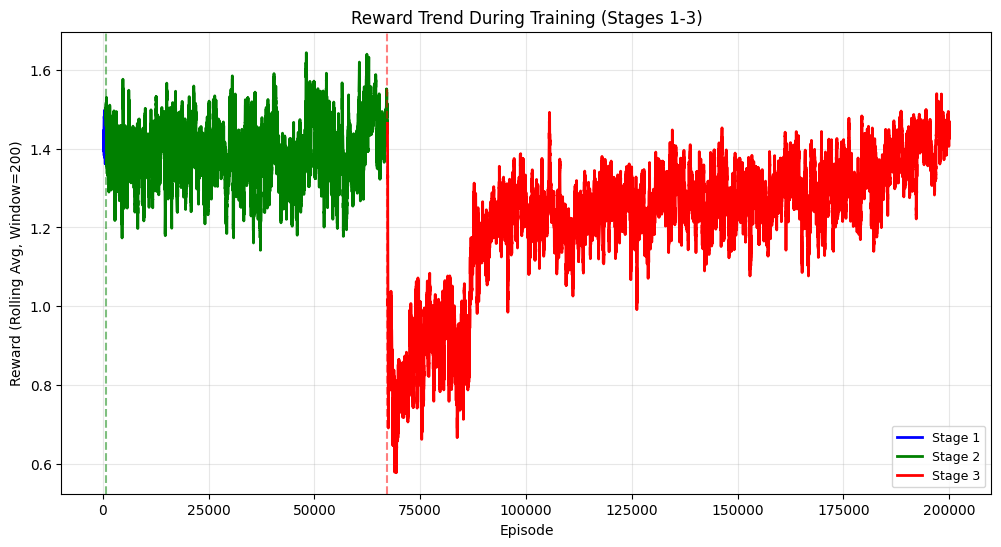

In [26]:
# Reward trends
plot_metric(stage1_3_df, 'reward', 200,
            title='Reward Trend During Training (Stages 1-3)')

Below is the win rate during stage 1-3. We could see the agent manage to stablize its win rate around 90% agnist a random strategy.

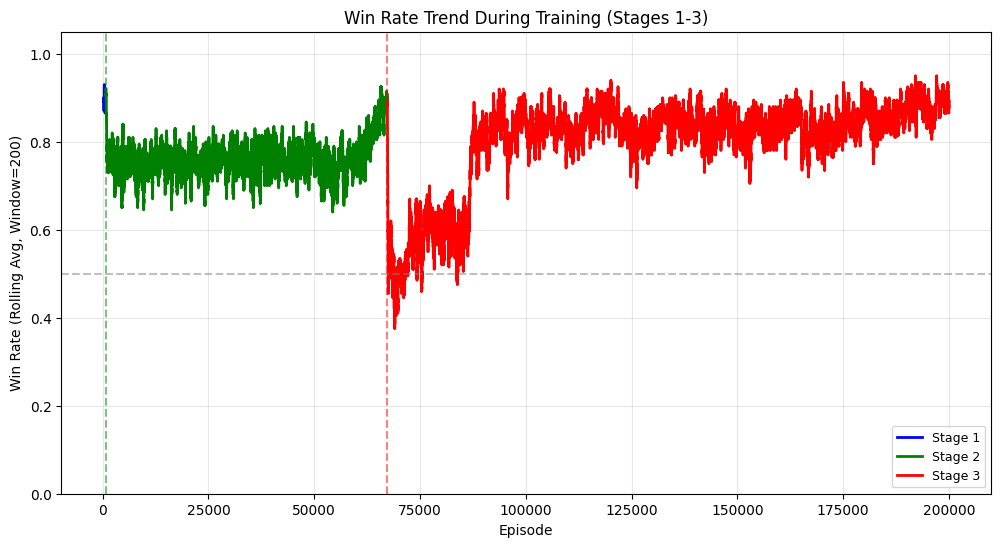

In [28]:
plot_metric(stage1_3_df, 'win', 200,
            title='Win Rate Trend During Training (Stages 1-3)',
            y_label=f'Win Rate (Rolling Avg, Window={200})',
            add_baseline=True)

As this game has a large action space and stochastical movement, we also plot the invalid moves changes to reflect on how agent leant along the way. The downward trend is align with expectation as the agent gets penalty when it makes a invalid action and thus make fewer as traning progresses.

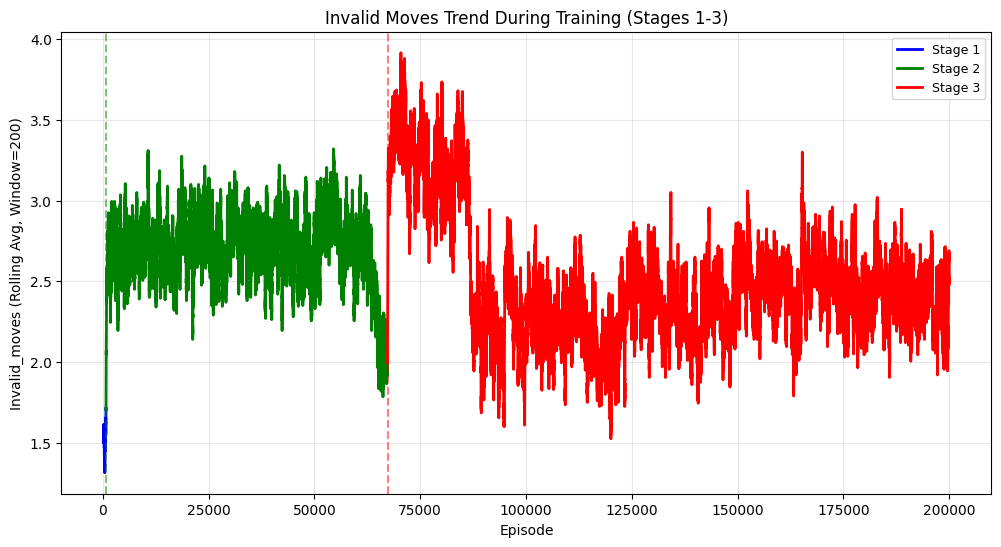

In [29]:
# Invalid moves
plot_metric(stage1_3_df, 'invalid_moves', 200,
            title='Invalid Moves Trend During Training (Stages 1-3)')

### 5.2 Stage 4
After the agent successufully win 50 games in a row in a full cross aganist a random strategy, it proceeded to stage 4  playing against previous versions of itself from different training stages, known as role play. The naming style of the oppoent is:  For s3ep70000, it means this is the checkpoint of agent in the episode 70000 from stage 3.  

We could see that the rewards that the agent gets is overall a downward trend, as the agent gradually faces increasingly sophisticated opponents (later checkpoints).

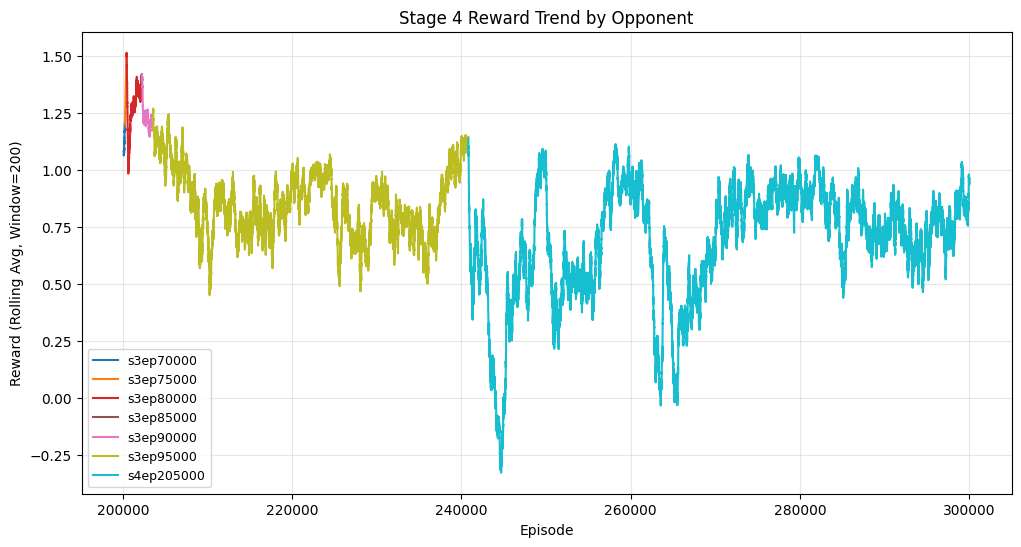

In [31]:
plot_metric(stage4_df, 'reward', 200,
            title='Stage 4 Reward Trend by Opponent',
            include_stages=False)

Similarily below is the win rate. We can see that once the agent faces a new opponent, its win rate has a immediate dropdown and gradually increases after traning.  

Worth mentioning that the blue line is the opponent who loads the first checkpoint of agent in stage 4. The agent's win rate aganist this opponent has a massive drop down, reflecting on how much more skills the agents gets once it starts role play trainning.

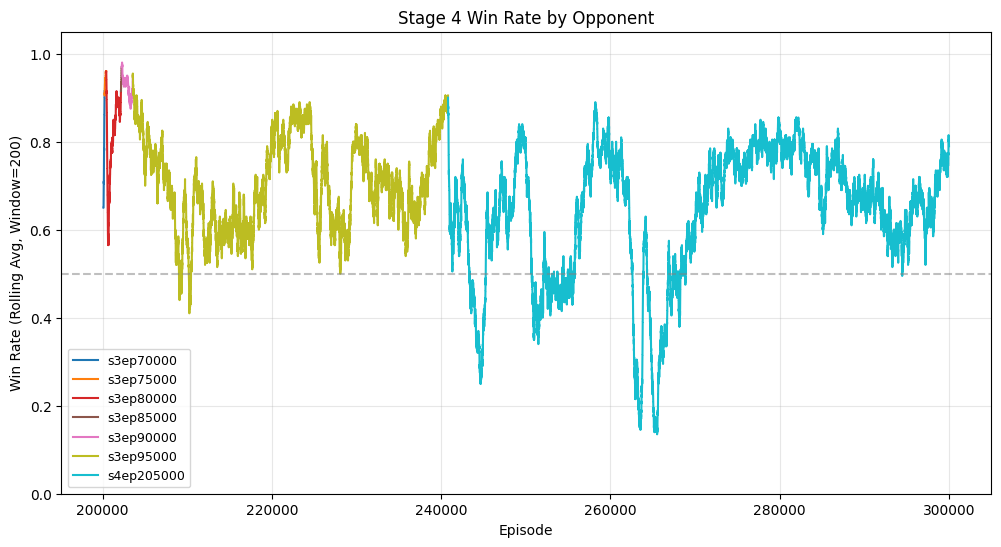

In [32]:
plot_metric(stage4_df, 'win', 200,
            title='Stage 4 Win Rate by Opponent',
            y_label=f'Win Rate (Rolling Avg, Window={200})',
            include_stages=False, add_baseline=True)

Similar for invalid moves

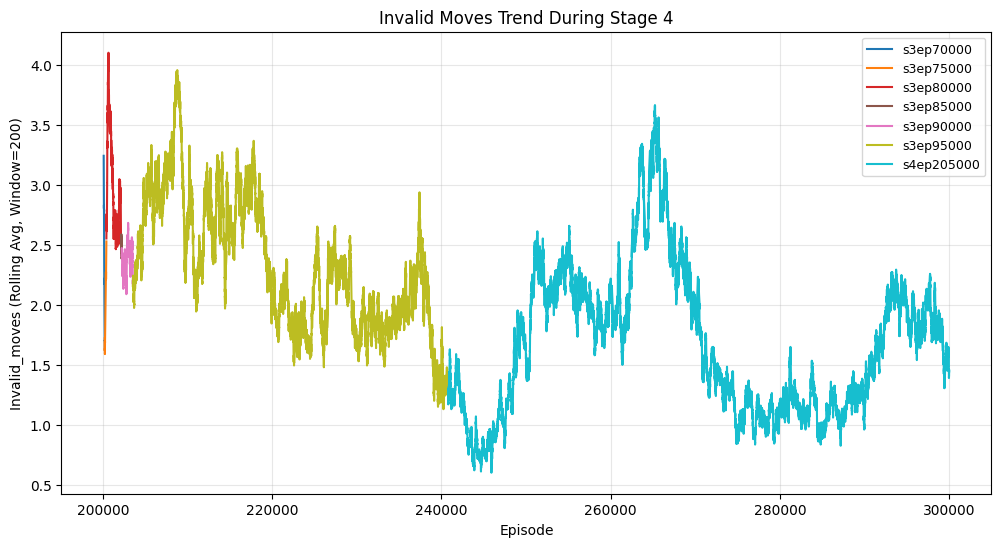

In [34]:
plot_metric(stage4_df, 'invalid_moves', 200,
            title='Invalid Moves Trend During Stage 4',
            include_stages=False)

Below is the average win rate during traning of agent playing aganist differnt opponetns.   

As the opponents adopt later checkpoints (more advanced models), the agent's win rate decreases, which indicates that our training is effective - the agent's strength improves as training progresses.

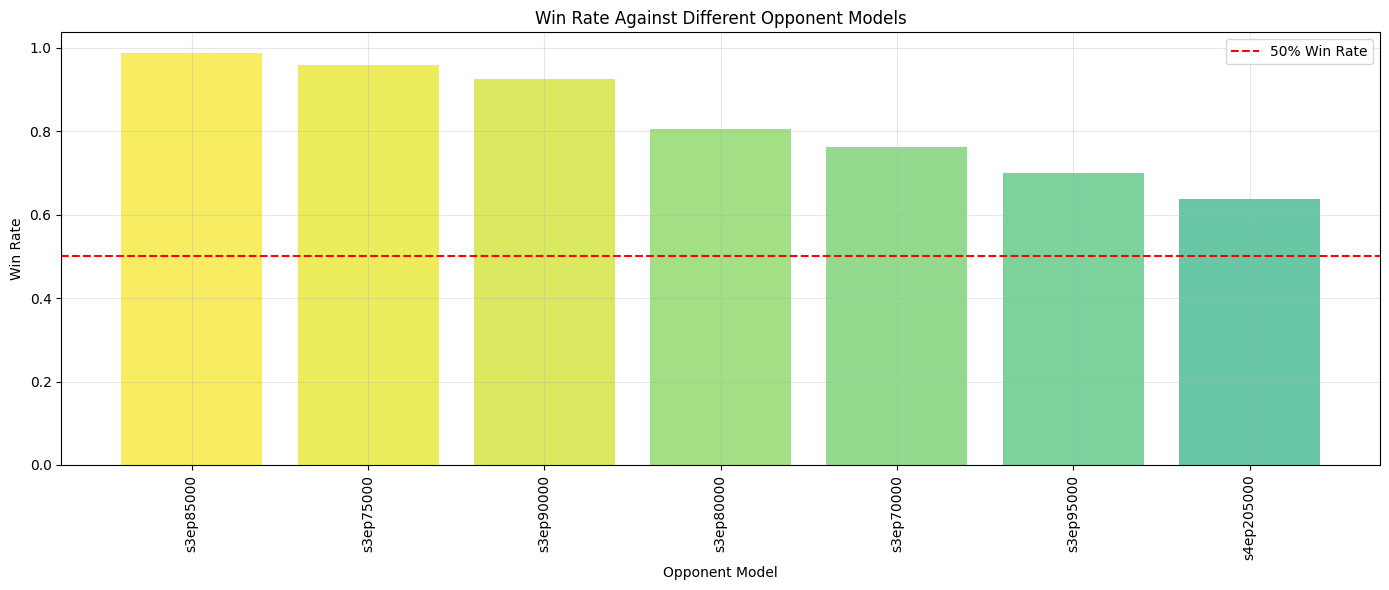

In [37]:
plot_opponent_performance(stage4_df)